# PHYS 309 T1 Measurement for salt water

Nov. 15, 2017

In [1]:
# Some math and stats functions I'll need
%pylab inline
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.stats import sem, chisquare

# Seaborn helps make my plots prettier
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_context('paper', font_scale=1.4)

# Used to load and sort my data
from os import listdir
from natsort import natsorted
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define some useful functions I'll use many times
def load_data(dir_regex_str, pol_t_path):
    """Load the data from the directory selected by dir_regex_str and the pol_t_path
    INPUTS:
        - (String) dir_regex_str: Regex expression to find the directory with all the data for one concentration of salt.
        - (String)    pol_t_path: Relative path to a file containing the polarization times used.
    OUTPUTS:
        - (3D numpy array) data: the time domain signal for each run and polarization time.
        - (numpy array)       t: array of times sampled, this was kept the same for all runs. In ms.
        - (numpy array)   pol_t: array of polarization times used in ms.
    """
    
    data_dirs = natsorted(glob.glob(dir_regex_str))
    data_sets = [natsorted(glob.glob(ds + '/data*')) for ds in data_dirs]
    data = []
    for data_set in data_sets:
        data.append([np.loadtxt(f) for f in data_set])

    t = linspace(0, 1200, 12000)  # we kept the default time sampling for each trial, in ms
    pol_t = loadtxt(pol_t_path)
    return data, t, pol_t

In [3]:
def model(t, T1, M0, d):
    return M0 * (1-exp(-t/T1)) + d

## $T_1$ for 10.22g of dissolved salt

In [4]:
# load all the data for 10.22g of salt
data, t, pol_t = load_data('./nov15/10*', './nov15/10_22gsaltwaterset1/array.txt')

In [5]:
np.shape(data)

(3, 30, 12000)

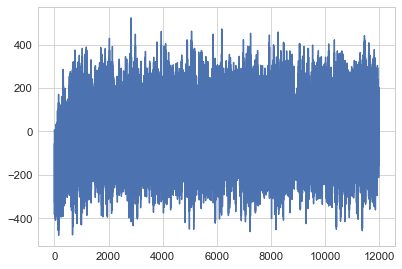

In [6]:
plot(data[0][0])

## Try using the maximum of the signal peak

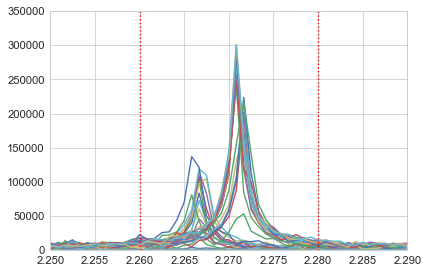

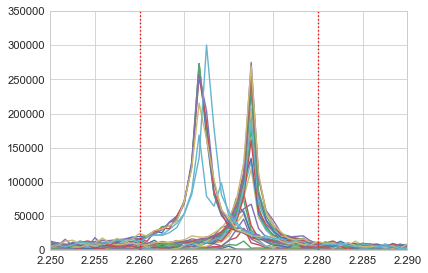

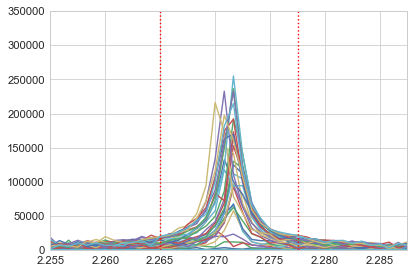

In [7]:
peak_maxes = zeros((shape(data)[0], len(pol_t)))

plot_flag = True  # flag to turn plotting on and off

# rough estimate of peak location. change these to find signal peak
peak_lims = [[2.26, 2.28],
            [2.26, 2.28],
            [2.265, 2.2775]]

for m in range(shape(data)[0]):
    peak_lim = peak_lims[m]

    if plot_flag:
        figure()

    for n in range(len(pol_t)):
        F = fft.fft(data[m][n])
        freq = fft.fftfreq(len(F), .1)  # each step is 0.1ms

        peak = where(logical_and(freq > peak_lim[0], freq < peak_lim[1])) 
        peak_maxes[m][n] = max(abs(F[peak]))

        if plot_flag:
            #figure()  # uncomment to plot separately
            plot(freq, abs(F))
            # find the signal by changing the x range
            xlim([peak_lim[0]-.01, peak_lim[1]+.01])  # kHz
            ylim([0, 350000])

    axvline(peak_lim[0], color='r', linestyle=':')
    axvline(peak_lim[1], color='r', linestyle=':')

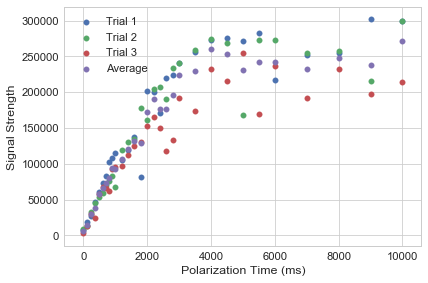

In [8]:
# Calculate the mean and the standard error in the mean of all the trials
avg_peak_maxes = mean(peak_maxes, axis=0)
err_peak_maxes = sem(peak_maxes, axis=0)

scatter(pol_t, peak_maxes[0], label='Trial 1')
scatter(pol_t, peak_maxes[1], label='Trial 2')
scatter(pol_t, peak_maxes[2], label='Trial 3')
scatter(pol_t, avg_peak_maxes, label='Average')
legend()
xlabel('Polarization Time (ms)')
ylabel('Signal Strength')

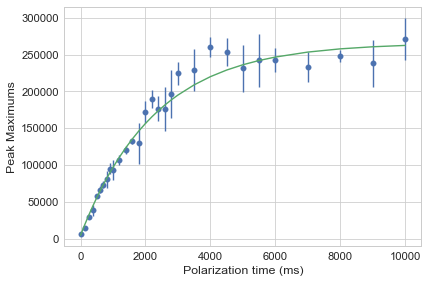

In [9]:
popt_max, pcov_max = curve_fit(model, pol_t, avg_peak_maxes, sigma=err_peak_maxes, p0=[2700, 250000, 50])
scatter(pol_t, avg_peak_maxes)
errorbar(pol_t, avg_peak_maxes, err_peak_maxes, linestyle='None')
plot(pol_t, model(pol_t, *popt_max))
xlabel('Polarization time (ms)')
ylabel('Peak Maximums')

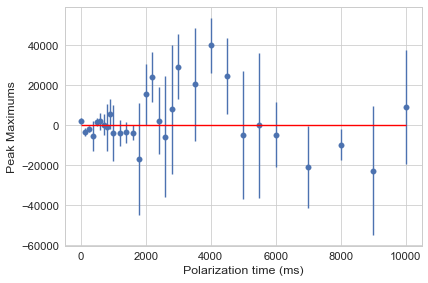

In [10]:
# Plot the residuals
model_pnts = model(pol_t, *popt_max)
residuals = avg_peak_maxes - model_pnts
scatter(pol_t, residuals)
errorbar(pol_t, residuals, err_peak_maxes, linestyle='None')
hlines(0, 0, 10000, colors='r')
xlabel('Polarization time (ms)')
ylabel('Peak Maximums')

In [11]:
chisquare(avg_peak_maxes, model_pnts, ddof=3.)

Power_divergenceResult(statistic=31854.595579730129, pvalue=0.0)

Based on the patterns in the residuals and the p value < 0.05, the model probably doesn't fit. Using the maximum of the peak at each polarization time does not seem to work. I should try something else.

## Try using the area under the peak

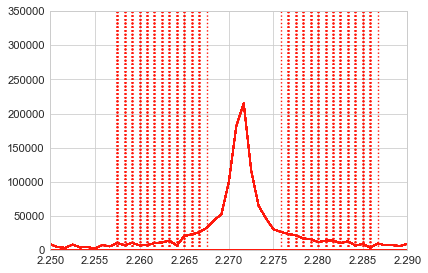

In [12]:
plot_fits = False  # flag to turn plotting on and off
plot_residuals = False
plot_peak_lims = True
plot_T1s = False

cmap = plt.get_cmap('rainbow')  # colors for the plots 
    
# rough estimate of peak location. change these to find signal peak
peak_lims = [[2.26, 2.28],
            [2.26, 2.28],
            [2.26, 2.28]]

peak_widths = linspace(0.01, 0.03, 100) # peak widths to try

T1s = []      # store T1s calculated with different peak limits
T1_errs = []  # store the errors associated with the T1s 
chi2s = []    # store the chi2 values
pvalues = []  # store p-values to evaluate goodness of fit

for peak_width in peak_widths:
    peak_areas = zeros((shape(data)[0], len(pol_t)))

    for m in range(shape(data)[0]): # for each trial
        peak_lim = peak_lims[m]

        for n in range(len(pol_t)):  # for each polarization time
            # Calculate the discrete fourier transform and frequency
            F = fft.fft(data[m][n])
            freq = fft.fftfreq(len(F), .1)  # each step is 0.1ms
            peak = logical_and(freq > peak_lim[0], freq < peak_lim[1])  # logical index for locating the peak
            peak_max = max(abs(F[peak]))
            # redefine the peak area around the signal peak max
            peak_max_freq = freq[logical_and(abs(F) == peak_max, peak)]
            peak = logical_and(freq > peak_max_freq-peak_width/2, freq < peak_max_freq+peak_width/2)
            peak_areas[m][n] = simps(abs(F[peak]), freq[peak])  # calculate the area under the peak using simpson's rule
        
            avg_peak_areas = mean(peak_areas, axis=0)
            
            if plot_peak_lims and m==2 and n==29:
                # figure()  # uncomment to plot separately
                c = cmap(float(n)/len(pol_t))
                plot(freq, abs(F), color=c)
                xlim([peak_lim[0]-.01, peak_lim[1]+.01])  # kHz
                ylim([0, 350000])
                axvline(freq[peak][0], linestyle=':', color=c)
                axvline(freq[peak][-1], linestyle=':', color=c)
            
        err_peak_areas = sem(peak_areas, axis=0)
        popt, pcov = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=[2400, 800, 50])

        model_pnts = model(pol_t, *popt)
        chi2, p = chisquare(avg_peak_areas, model_pnts, ddof=3.)

        if plot_fits:
            figure()
            scatter(pol_t, avg_peak_areas)
            errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
            plot(pol_t, model_pnts)
            xlabel('Polarization time (ms)')
            ylabel('Peak Areas')

        if plot_residuals:
            figure()
            residuals = avg_peak_areas - model_pnts
            scatter(pol_t, residuals)
            errorbar(pol_t, residuals, err_peak_areas, linestyle='None')
            hlines(0, 0, 10000, colors='r')
            xlabel('Polarization Time (ms)')
            ylabel('Residuals')
            
    T1s.append(popt[0])
    T1_errs.append(sqrt(diag(pcov))[0])
    pvalues.append(p)
    chi2s.append(chi2)
    
T1s = array(T1s)
pvalues = array(pvalues)
chi2s = array(chi2s)

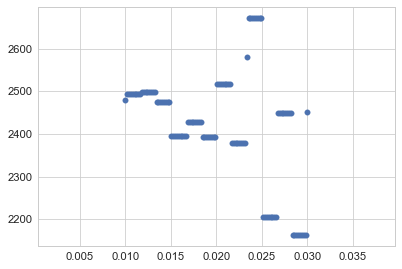

In [13]:
scatter(peak_widths, T1s)

2424.49998473 12.9505982054


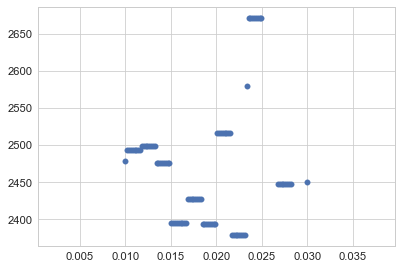

In [14]:
scatter(peak_widths[pvalues > 0.05], T1s[pvalues > 0.05])
#ylim([2393, 2394])
print(mean(T1s), sem(T1s))


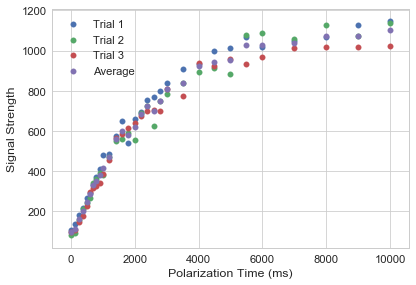

In [15]:
# Calculate the mean and the standard error in the mean
avg_peak_areas = mean(peak_areas, axis=0)
err_peak_areas = sem(peak_areas, axis=0)

scatter(pol_t, peak_areas[0], label='Trial 1')
scatter(pol_t, peak_areas[1], label='Trial 2')
scatter(pol_t, peak_areas[2], label='Trial 3')
scatter(pol_t, avg_peak_areas, label='Average')
legend()
xlabel('Polarization Time (ms)')
ylabel('Signal Strength')

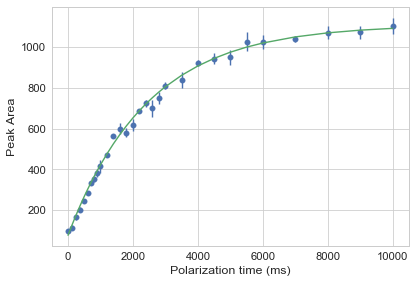

In [16]:
popt_area, pcov_area = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=[2700, 1000, 50])
scatter(pol_t, avg_peak_areas)
errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
plot(pol_t, model(pol_t, *popt_area))
xlabel('Polarization time (ms)')
ylabel('Peak Area')

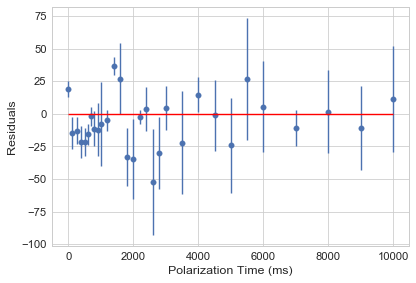

In [17]:
# Plot the residuals
area_model_pnts = model(pol_t, *popt_area)
area_residuals = avg_peak_areas - area_model_pnts
scatter(pol_t, area_residuals)
errorbar(pol_t, area_residuals, err_peak_areas, linestyle='None')
hlines(0, 0, 10000, colors='r')
xlabel('Polarization Time (ms)')
ylabel('Residuals')

In [18]:
chisquare(avg_peak_areas, area_model_pnts, ddof=3.)

Power_divergenceResult(statistic=27.845398786708486, pvalue=0.36610791865196168)

In [19]:
popt_area

array([ 2451.081317  ,  1032.42334898,    76.89979862])

In [20]:
sqrt(diag(pcov_area))

array([ 95.69462965,  19.30089824,   6.9944006 ])

The residuals and p value > 0.05 indicates that my model fits well. From my data, I measured $T_1$ for tap water with 10.22g of salt added to be:
$$T_1 = 2.39 \pm 0.074 s$$

## Using the maximum of the signal peak and varying the peak limits based on fraction of peak max

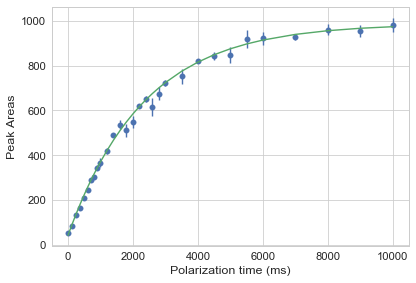

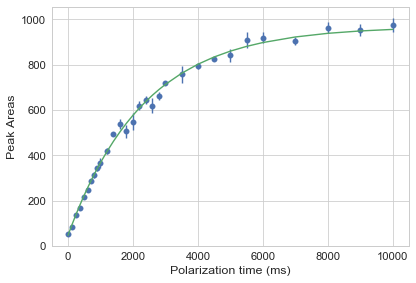

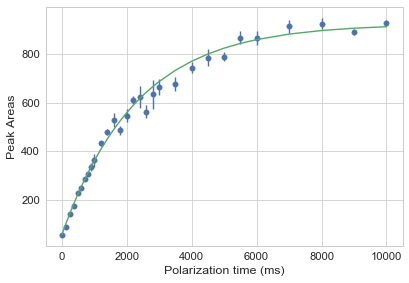

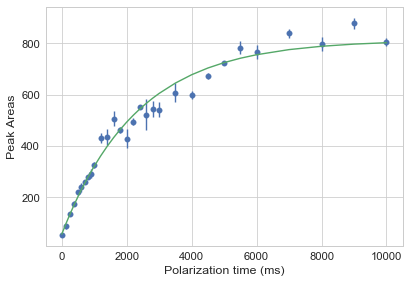

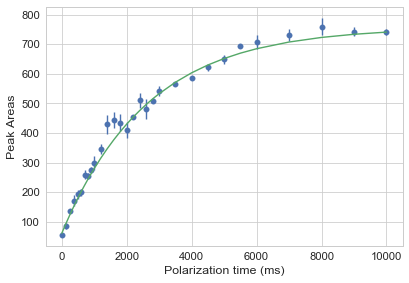

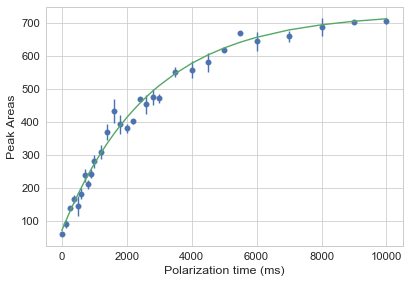

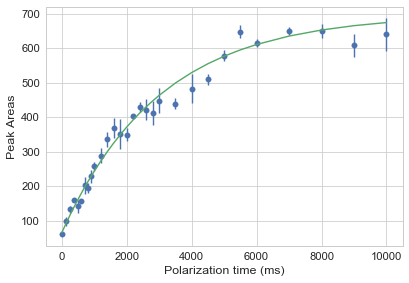

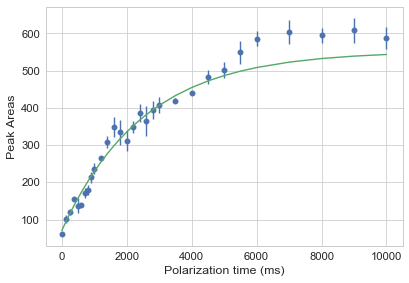

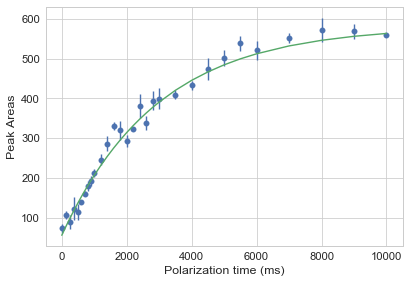

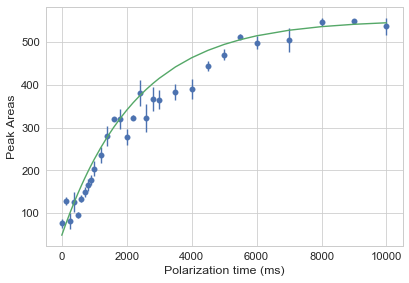

In [21]:
plot_fits = True  # flag to turn plotting on and off
plot_residuals = False
plot_peak_lims = False
plot_T1s = False
cmap = plt.get_cmap('rainbow')  # colors for the plots 
    
# rough estimate of peak location. change these to find signal peak
peak_lims = [[2.26, 2.28],
            [2.26, 2.28],
            [2.26, 2.28]]

max_fractions = linspace(0.01, 0.25, 10) # used to calculate peak limits
T1s = []      # store T1s calculated with different peak limits
T1_errs = []  # store the errors associated with the T1s 
chi2s = []    # store the chi2 values
pvalues = []  # store p-values to evaluate goodness of fit

for max_fraction in max_fractions:
    peak_areas = zeros((shape(data)[0], len(pol_t)))

    for m in range(shape(data)[0]): # for each trial
        peak_lim = peak_lims[m]

        for n in range(len(pol_t)):  # for each polarization time
            
            # Calculate the discrete fourier transform and frequency
            F = fft.fft(data[m][n])
            freq = fft.fftfreq(len(F), .1)  # each step is 0.1ms
            peak = logical_and(freq > peak_lim[0], freq < peak_lim[1])  # logical index for locating the peak
            peak_max = max(abs(F[peak]))
            
            # redefine the peak area around the signal peak max
            peak_max_freq = freq[logical_and(abs(F) == peak_max, peak)]
            peak = logical_and(abs(F) > peak_max*max_fraction, peak)
            peak_areas[m][n] = simps(abs(F[peak]), freq[peak])  # calculate the area under the peak using simpson's rule
            
            if plot_peak_lims and n==25:
                figure()
                c = cmap(float(n)/len(pol_t))
                scatter(freq, abs(F), color=c)
                xlim([peak_lim[0]-.01, peak_lim[1]+.01])  # kHz
                ylim([0, 350000])
                axvline(freq[peak][0], linestyle=':', color=c)
                axvline(freq[peak][-1], linestyle=':', color=c)
                hlines(peak_max*max_fraction, 0, 10000, colors='r')

    avg_peak_areas = mean(peak_areas, axis=0)
    err_peak_areas = sem(peak_areas, axis=0)
    popt, pcov = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=[2400, 800, 50])
    
    model_pnts = model(pol_t, *popt)
    chi2, p = chisquare(avg_peak_areas, area_model_pnts, ddof=3.)
    
    T1s.append(popt[0])
    T1_errs.append(sqrt(diag(pcov))[0])
    pvalues.append(p)
    chi2s.append(chi2)
    
    if plot_fits:
        figure()
        scatter(pol_t, avg_peak_areas)
        errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
        plot(pol_t, model_pnts)
        xlabel('Polarization time (ms)')
        ylabel('Peak Areas')
        
    if plot_residuals:
        figure()
        residuals = avg_peak_areas - model_pnts
        scatter(pol_t, residuals)
        errorbar(pol_t, residuals, err_peak_areas, linestyle='None')
        hlines(0, 0, 10000, colors='r')
        xlabel('Polarization Time (ms)')
        ylabel('Residuals')
        
T1s = array(T1s)
pvalues = array(pvalues)
max_fractions = array(max_fractions)

(2320, 2360)

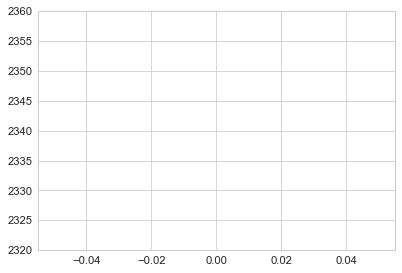

In [22]:
T1s = array(T1s)
pvalues = array(pvalues)
max_fractions = array(max_fractions)

scatter(max_fractions[pvalues>0.05], T1s[pvalues>0.05])
ylim([2320, 2360])

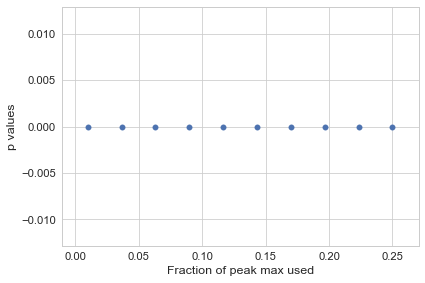

In [23]:
scatter(max_fractions, pvalues)
ylabel('p values')
xlabel('Fraction of peak max used')

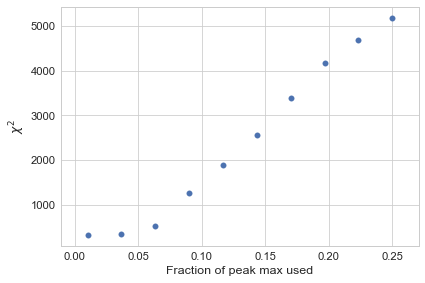

In [24]:
scatter(max_fractions, chi2s)
ylabel('$\chi^2$')
xlabel('Fraction of peak max used')

Using this method doesn't ever seem to give me a good fit with p > 0.05 no matter which fration of the peak max I use. I will go back to method 2, where I calculated the area under the peak for various preset peak limits. 

I think this method doesn't work because the points get quite sparse near the peak so that getting the points greater than a fraction of the peak max returns potentially different ranges of points. The randomness of the points can make it so that points near the fraction of peak max I'm selecting for is sometimes selected and sometimes not selected.

This is why having a consistent peak width for each run might be a better estimation of the signal strength.

I will use method 2 for the rest of my data analysis. Since this notebook already got pretty long, I will analyse the other salt concentrations in another notebook.